# 🧮 Bài toán kế hoạch lập ngân sách mua sắm

Trong notebook này, chúng tôi thực hiện giải bài toán **Knapsack (Balo)** bằng nhiều phương pháp khác nhau:
- Greedy (Tham lam)
- Dynamic Programming (Quy hoạch động)
- Branch and Bound (Nhánh và cận)
- OR-Tools (Tối ưu hóa tuyến tính)

Mục tiêu là **chọn ra các món hàng sao cho tổng chi phí không vượt quá ngân sách**, nhưng tổng giá trị là lớn nhất.

File dữ liệu: `items.json`, chứa danh sách các món hàng với `cost` và `value`.

In [1]:
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import heapq
from ortools.linear_solver import pywraplp

In [2]:
def load_items_from_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

### Thuật toán Greedy (Tham lam)
Thuật toán Greedy lựa chọn các món hàng dựa trên **tỷ lệ giá trị / chi phí** (`value/cost`) cao nhất trước. 
Ý tưởng là chọn món có "lợi" nhất cho đến khi không thể thêm được nữa do vượt quá ngân sách.
#### Ưu điểm:
- Rất nhanh, phù hợp với dữ liệu lớn.
- Cài đặt đơn giản.
#### Nhược điểm:
- Không đảm bảo cho ra kết quả tối ưu.
- Phụ thuộc vào chiến lược sắp xếp ban đầu.
#### Ứng dụng:
- Dùng như lời giải xấp xỉ khi không cần chính xác tuyệt đối.

### Thuật toán Greedy

Thuật toán này chọn các món hàng theo tỷ lệ `value/cost` giảm dần cho đến khi hết ngân sách. Đây là giải pháp gần đúng, thời gian chạy nhanh nhưng không đảm bảo tối ưu.


In [3]:
def greedy_knapsack(items, budget):
    start_time = time.time()
    items.sort(key=lambda x: x['value'] / x['cost'], reverse=True)
    total_cost, total_value = 0, 0
    selected_items = []
    
    for item in items:
        if total_cost + item['cost'] <= budget:
            selected_items.append(item['name'])
            total_cost += item['cost']
            total_value += item['value']
    
    end_time = time.time()
    print("Greedy Solution:")
    print("Chọn:", selected_items)
    print("Tổng giá trị:", total_value, "\n")
    return total_value, end_time - start_time

### Thuật toán Quy hoạch động (Dynamic Programming - DP)

Thuật toán DP xây dựng bảng `dp[i][w]` đại diện cho giá trị tối đa đạt được khi xét đến `i` món đầu tiên và giới hạn ngân sách `w`.

#### Ý tưởng chính:
- Với mỗi món hàng, có hai lựa chọn: chọn hoặc không chọn.
- Sử dụng bảng lưu trữ để tránh tính toán lặp lại.

#### Ưu điểm:
- Đảm bảo tìm được lời giải tối ưu.
- Hiểu rõ cấu trúc bài toán con.

#### Nhược điểm:
- Tốn bộ nhớ và thời gian khi ngân sách lớn.


### Thuật toán Quy hoạch động (Dynamic Programming)

Giải pháp chính xác cho bài toán Knapsack bằng cách xây dựng bảng giá trị tối ưu cho từng trọng số từ 0 đến ngân sách.


In [4]:
def dp_knapsack(items, budget):
    start_time = time.time()
    n = len(items)
    dp = [[0] * (budget + 1) for _ in range(n + 1)]
    
    for i in range(1, n + 1):
        cost = items[i - 1]['cost']
        value = items[i - 1]['value']
        for w in range(budget + 1):
            if cost <= w:
                dp[i][w] = max(dp[i - 1][w], dp[i - 1][w - cost] + value)
            else:
                dp[i][w] = dp[i - 1][w]
    
    end_time = time.time()
    print("DP Solution:")
    print("Tổng giá trị tối ưu:", dp[n][budget], "\n")
    return dp[n][budget], end_time - start_time


### Thuật toán Nhánh và Cận (Branch and Bound - BnB)

BnB là phương pháp thử tất cả các khả năng nhưng sử dụng kỹ thuật **cắt tỉa** (pruning) để loại bỏ các nhánh không cần thiết.

#### Cách hoạt động:
- Mỗi bước quyết định chọn hoặc bỏ món hàng.
- Tính toán giới hạn trên để loại bỏ nhánh không có tiềm năng.

#### Ưu điểm:
- Tối ưu hơn so với vét cạn (brute-force).
- Có thể tìm lời giải tốt trong thời gian hợp lý.

#### Nhược điểm:
- Hiệu quả phụ thuộc vào cách sắp xếp và giới hạn ước lượng.


### Thuật toán Nhánh và Cận (Branch and Bound)

Sử dụng cây trạng thái để xét các khả năng lựa chọn, đồng thời loại bỏ nhánh không cần thiết dựa trên giới hạn cận.


In [1]:
def branch_and_bound_knapsack(items, budget):
    start_time = time.time()
    items.sort(key=lambda x: x['value'] / x['cost'], reverse=True)
    n = len(items)
    max_value = 0
    queue = []
    heapq.heappush(queue, (-items[0]['value'], 0, 0, 0))
    
    while queue:
        neg_upper_bound, level, total_cost, total_value = heapq.heappop(queue)
        
        if level >= n:
            continue
        
        next_item = items[level]
        if total_cost + next_item['cost'] <= budget:
            new_total_cost = total_cost + next_item['cost']
            new_total_value = total_value + next_item['value']
            heapq.heappush(queue, (-new_total_value, level + 1, new_total_cost, new_total_value))
            
            if new_total_value > max_value:
                max_value = new_total_value
        
        heapq.heappush(queue, (-total_value, level + 1, total_cost, total_value))
    
    end_time = time.time()
    print("Branch and Bound Solution:")
    print("Tổng giá trị:", max_value, "\n")
    return max_value, end_time - start_time

### Thuật toán sử dụng OR-Tools (Tối ưu hóa tuyến tính nguyên)

Thư viện OR-Tools của Google hỗ trợ giải bài toán tối ưu bằng nhiều phương pháp hiện đại như **Linear Programming** hay **Mixed Integer Programming**.

#### Cách sử dụng:
- Biểu diễn bài toán dưới dạng mô hình toán học: biến quyết định, ràng buộc, hàm mục tiêu.
- Gọi solver phù hợp (ví dụ: `SCIP`, `CBC`, ...).

#### Ưu điểm:
- Hiện đại, dễ sử dụng.
- Thường cho kết quả tốt và nhanh.

#### Nhược điểm:
- Cần cài đặt thêm thư viện.
- Phải hiểu mô hình hóa bài toán.

#### Ứng dụng:
- Các hệ thống tối ưu thực tế, logistics, tài chính, lập lịch.


### Thuật toán sử dụng OR-Tools

Tận dụng thư viện tối ưu hóa OR-Tools của Google để giải bài toán một cách hiệu quả.


In [6]:
def ortools_linear_knapsack(items, budget):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        return 0, 0
    
    item_vars = [solver.BoolVar(f'x{i}') for i in range(len(items))]
    solver.Maximize(solver.Sum(items[i]['value'] * item_vars[i] for i in range(len(items))))
    solver.Add(solver.Sum(items[i]['cost'] * item_vars[i] for i in range(len(items))) <= budget)
    
    start_time = time.time()
    status = solver.Solve()
    end_time = time.time()
    
    if status == pywraplp.Solver.OPTIMAL:
        total_value = solver.Objective().Value()
        print("OR-Tools Linear Programming Solution:")
        print(f"Tổng giá trị: {total_value}")
        return total_value, end_time - start_time
    else:
        print("Không tìm thấy giải pháp tối ưu.")
        return 0, end_time - start_time

## ▶️ Chạy thử nghiệm và so sánh kết quả

Trong phần này, chúng tôi sẽ:
- Đọc dữ liệu từ file
- Thiết lập ngân sách
- Gọi các hàm giải quyết bài toán
- So sánh thời gian chạy và kết quả đạt được

OR-Tools Linear Programming Solution:
Tổng giá trị: 24.0
Greedy Solution:
Chọn: ['Sữa hộp 1L', 'Trứng gà 10 quả', 'Bánh mì 500g', 'Dầu ăn 1L', 'Nước mắm 500ml', 'Gạo 5kg']
Tổng giá trị: 23 

DP Solution:
Tổng giá trị tối ưu: 24 

Branch and Bound Solution:
Tổng giá trị: 24 



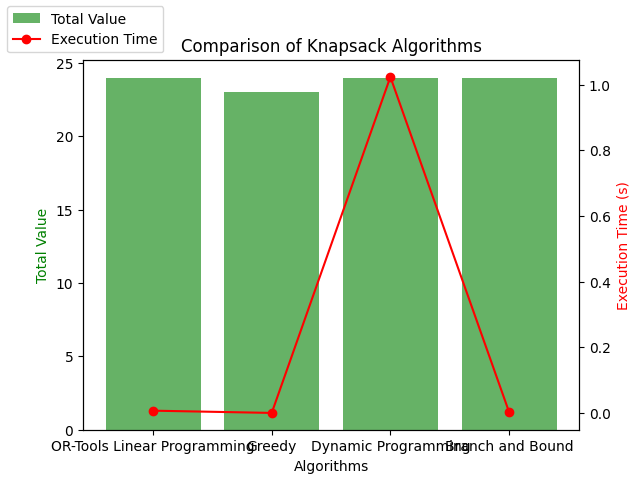

In [7]:
if __name__ == "__main__":
    budget = 500000
    items = load_items_from_json("items.json")
    
    results = {
        "OR-Tools Linear Programming": ortools_linear_knapsack(items, budget),
        "Greedy": greedy_knapsack(items, budget),
        "Dynamic Programming": dp_knapsack(items, budget),
                "Branch and Bound": branch_and_bound_knapsack(items, budget)
    }
    
    labels = list(results.keys())
    values = [res[0] for res in results.values()]
    times = [res[1] for res in results.values()]
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.bar(labels, values, color='g', alpha=0.6, label='Total Value')
    ax2.plot(labels, times, color='r', marker='o', label='Execution Time')
    
    ax1.set_xlabel("Algorithms")
    ax1.set_ylabel("Total Value", color='g')
    ax2.set_ylabel("Execution Time (s)", color='r')
    ax1.set_title("Comparison of Knapsack Algorithms")
    
    fig.legend(loc='upper left')
    plt.show()

## 📊 Tổng kết & Nhận xét

| Thuật toán                  | Giá trị đạt được | Thời gian (giây) | Nhận xét                                                           |
|-----------------------------|------------------|------------------|---------------------------------------------------------------------|
| Greedy                     | 23               | Nhanh            | Rất nhanh, đơn giản, nhưng không tìm được kết quả tối ưu            |
| Dynamic Programming (DP)   | 24               | Trung bình       | Đạt kết quả tối ưu, phù hợp với dữ liệu nhỏ hoặc vừa                |
| Branch and Bound (BnB)     | 24               | Chậm hơn DP      | Chính xác, phù hợp với dữ liệu không quá lớn, có thể bị chậm        |
| OR-Tools Linear Programming| 24.0             | Hiệu quả         | Hiện đại, tự động hóa tốt, cho kết quả tối ưu nhanh và ổn định      |

👉 Như vậy, các thuật toán DP, BnB và OR-Tools đều cho ra **giá trị tối ưu là 24**, trong khi **Greedy** chỉ đạt **23** do tính chất xấp xỉ.

**Lời khuyên**:
- Dữ liệu nhỏ: DP hoặc BnB là lựa chọn tốt.
- Dữ liệu lớn: Dùng OR-Tools để tận dụng sức mạnh mô hình tối ưu hóa hiện đại.
- Khi cần tốc độ hơn độ chính xác: Greedy vẫn là lựa chọn nhẹ và nhanh.

